# Figure 2: Host DNA percentage

## A: Human host DNA percentage

Importing libraries

In [22]:
import multiprocessing
import pandas as pd
import subprocess
import pysam
import os
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import ptitprince as pt
from plotnine import *

### Summary of BAM files generate by [Anonymap](https://github.com/maxibor/anonymap)

|     Lab    |    Contact    | Origin of samples | Number of samples | Reference human genome used | Westernized ?|
|:----------:|:-------------:|:-----------------:|:-----------------:|:---------------------------:|:-------------|
| Kostic Lab | Marsha Wibowo |         ?         |         49        |            GRCh38           |      yes     |
|  Lewis Lab |  Tanvi Honap  |    Burkina Faso   |         69        |             hg19            |       no     | 
|PRJEB35961 BGISEQ |     -     |    China          |         39        |             GRCh38          |     yes    |

Setting up the list of bam files

In [9]:
human_non_western_bam_dir = "../../data/lewis_lab"
human_non_western_bams = [i for i in os.listdir(human_non_western_bam_dir) if i.endswith(".bam")]
human_western_bam_dir = "../../data/kostic_lab" 
human_western_bams = [i for i in os.listdir(human_western_bam_dir) if i.endswith(".bam")]

Defining filtering values:

In [10]:
min_id = 0.95
min_len = 20

Defining functions to parse alignment files

In [10]:
def bam_index(bam, bamdir):
    #print(bam)
    cmd = f"samtools index {bamdir}/{bam}"
    try:
        #print(cmd)
        subprocess.check_output(cmd, shell=True)
    except subprocess.CalledProcessError:
        #print(f"Error indexing {bam}")
        pass

In [11]:
def perChromosome(chr, bam, min_id, min_len):
    mapped = 0
    bamfile = pysam.AlignmentFile(bam, "rb")
    reads = bamfile.fetch(chr, multiple_iterators=True)
    for read in reads:
        try:
            cigar = read.get_cigar_stats()[0]
            cigar_d = {'M':cigar[0], 'I': cigar[1], 'D': cigar[2], 'NM': cigar[-1]}
            aln_cols = cigar_d['M']+cigar_d['I']+cigar_d['D']
            nm = cigar_d['NM']
            if cigar_d['M'] == 0:
                continue
            else:
                identity = (aln_cols-nm)/(aln_cols)
                if identity >= min_id and aln_cols >= min_len :
                    mapped +=1
        except:
            continue
    return(mapped)

def getNumberMappedReadsMultiprocess(bam, processes, min_id, min_len):
    try:
        bamfile = pysam.AlignmentFile(bam, "rb")
    except ValueError as e:
        print(e)
    chrs = bamfile.references

    perChromosomePartial = partial(
        perChromosome, bam=bam, min_id = min_id, min_len = min_len)
    p = multiprocessing.Pool(processes)
    result = p.imap_unordered(perChromosomePartial, chrs)
    p.close()
    p.join()
    mapped = sum(result)
    total = bamfile.mapped + bamfile.unmapped
    return({bam.split("/")[-1].split(".")[0]:[mapped, total]})   

#### Handling westernized bam files 

In [ ]:
index_western = partial(bam_index, bamdir = human_western_bam_dir)
with multiprocessing.Pool(10) as p:
    p.map(index_western, human_western_bams)

In [12]:
western_res = {}
for i in tqdm(human_western_bams):
    western_res.update(getNumberMappedReadsMultiprocess(bam = f"{human_western_bam_dir}/{i}", processes=10, min_id = min_id, min_len=min_len))

100%|██████████| 49/49 [00:37<00:00,  1.37it/s]


In [14]:
western_human = pd.DataFrame(western_res).T
western_human.columns = 'human_count','all_count'
western_human["percentage_endo"] = western_human['human_count']/western_human['all_count']*100

In [15]:
western_human.head()

,human_count,all_count,percentage_endo
E5,175600,11487470,1.528622
F4,183259,9696234,1.890002
E2,214203,8327324,2.572291
E1,227278,10907632,2.083660
B10,375059,11695702,3.206811


In [16]:
western_human['percentage_endo'].describe()

count    49.000000
mean      1.808109
std       0.806107
min       0.409995
25%       1.258292
50%       1.667870
75%       2.228570
max       3.731088
Name: percentage_endo, dtype: float64

In [17]:
western_human.to_csv("results/western_human.csv")

In [25]:
western_human = pd.read_csv("results/western_human.csv", index_col=0)

In [26]:
western_human.head()

,human_count,all_count,percentage_endo
E5,175600,11487470,1.528622
F4,183259,9696234,1.890002
E2,214203,8327324,2.572291
E1,227278,10907632,2.083660
B10,375059,11695702,3.206811


In [27]:
western_human['organism'] = western_human.shape[0]*['Westernized human / Urban']

#### Handling non westernized bam files 

Because these files were anonymized for the mapping position as well, we can not index them and have to parse them manually from sam files

In [ ]:
def bam2sam(bamfile, bamdir):
    print(bamfile)
    basename = bamfile.split(".")[0]
    cmd = f"samtools view {bamdir}/{bamfile} > {bamdir}/{basename}.sam"
    print(cmd)
    subprocess.check_output(cmd, shell = True)

In [ ]:
non_western_bam2sam = partial(bam2sam, bamdir = human_non_western_bam_dir)
with multiprocessing.Pool(10) as p:
    p.map(western_bam2sam, human_non_western_bams)

In [63]:
regex = re.compile("(\d*)[MID]")
def samline(sam, regex=regex, min_id = min_id, min_len=min_len):
    print(sam)
    cnt = 0
    all_cnt = 0
    with open(sam, 'r') as f:
        for l in f:
            lsplit = l.split()
            cigar = lsplit[5]
            all_cnt +=1
            if len(cigar) > 1:
                tags = lsplit[16:18]
                for i in tags:
                    if i.split(':')[0] == 'NM':
                        nm = int(i.split(':')[-1])
                        break
                al_len = sum([int(i) for i in re.findall(regex, cigar)])
                ident = (al_len - nm)/al_len
                if ident >= min_id and al_len>=min_len:
                    cnt+=1
            else:
                continue
    return({sam:[cnt,all_cnt]})

In [58]:
human_non_western_sams = [i for i in os.listdir(human_non_western_bam_dir) if i.endswith(".sam")]

In [64]:
with multiprocessing.Pool(10) as p:
    res = list(tqdm(p.imap_unordered(samline, [f"{human_non_western_bam_dir}/{s}" for s in human_non_western_sams]), total=len(human_non_western_sams)))


  0%|          | 0/69 [00:00<?, ?it/s]

../../data/lewis_lab/bftm130122.sam


../../data/lewis_lab/bftm230440.sam
../../data/lewis_lab/bftm1502ecol15.sam
../../data/lewis_lab/bftm030236.sam
../../data/lewis_lab/bftm280135.sam
../../data/lewis_lab/bftm100113.sam
../../data/lewis_lab/bftm2301ext33.sam
../../data/lewis_lab/bftm2401ext31.sam
../../data/lewis_lab/bftm070332.sam
../../data/lewis_lab/bftm0401ecol39.sam



  1%|▏         | 1/69 [00:47<54:11, 47.81s/it]

../../data/lewis_lab/bftm140428.sam



  3%|▎         | 2/69 [01:08<44:14, 39.62s/it]

../../data/lewis_lab/bftm2103ext32.sam



  4%|▍         | 3/69 [01:11<31:30, 28.65s/it]

../../data/lewis_lab/bftm140127.sam



  6%|▌         | 4/69 [01:13<22:23, 20.67s/it]

../../data/lewis_lab/bftm040212.sam



  7%|▋         | 5/69 [01:47<26:26, 24.79s/it]

../../data/lewis_lab/bftm220210.sam



  9%|▊         | 6/69 [01:53<20:05, 19.14s/it]

../../data/lewis_lab/bftm110237.sam



 10%|█         | 7/69 [02:03<16:51, 16.31s/it]

../../data/lewis_lab/bftm1003ext22.sam



 12%|█▏        | 8/69 [02:18<16:12, 15.95s/it]

../../data/lewis_lab/bftm190220.sam



 13%|█▎        | 9/69 [02:20<11:47, 11.80s/it]

../../data/lewis_lab/bftm180134.sam



 14%|█▍        | 10/69 [03:08<22:22, 22.75s/it]

../../data/lewis_lab/bftm140341.sam



 16%|█▌        | 11/69 [03:22<19:24, 20.09s/it]

../../data/lewis_lab/bftm0202ext20.sam



 17%|█▋        | 12/69 [03:23<13:33, 14.27s/it]

../../data/lewis_lab/bftm270223.sam



 19%|█▉        | 13/69 [03:36<12:54, 13.84s/it]

../../data/lewis_lab/bftm0803ext30.sam



 20%|██        | 14/69 [04:00<15:23, 16.80s/it]

../../data/lewis_lab/bftm1002ecol4.sam



 22%|██▏       | 15/69 [04:23<16:53, 18.77s/it]

../../data/lewis_lab/bftm30016.sam



 23%|██▎       | 16/69 [04:32<13:51, 15.70s/it]

../../data/lewis_lab/bftm0601ext18.sam



 25%|██▍       | 17/69 [05:00<17:01, 19.65s/it]

../../data/lewis_lab/bftm2204ext27.sam



 26%|██▌       | 18/69 [05:40<21:46, 25.61s/it]

../../data/lewis_lab/bftm2801ext35.sam



 28%|██▊       | 19/69 [05:46<16:34, 19.89s/it]

../../data/lewis_lab/bftm1104ecol11.sam



 29%|██▉       | 20/69 [05:50<12:13, 14.97s/it]

../../data/lewis_lab/bftm060125.sam



 30%|███       | 21/69 [05:50<08:30, 10.63s/it]

../../data/lewis_lab/bftm2101ext26.sam



 32%|███▏      | 22/69 [06:01<08:17, 10.60s/it]

../../data/lewis_lab/bftm1303ext17.sam



 33%|███▎      | 23/69 [06:13<08:24, 10.96s/it]

../../data/lewis_lab/bftm2601ext24.sam



 35%|███▍      | 24/69 [06:34<10:34, 14.10s/it]

../../data/lewis_lab/bftm050238.sam



 36%|███▌      | 25/69 [06:40<08:32, 11.65s/it]

../../data/lewis_lab/bftm0701ecol12.sam



 38%|███▊      | 26/69 [07:11<12:26, 17.35s/it]

../../data/lewis_lab/bftm290124.sam



 39%|███▉      | 27/69 [07:23<11:00, 15.73s/it]

../../data/lewis_lab/bftm09037.sam



 41%|████      | 28/69 [07:48<12:39, 18.53s/it]

../../data/lewis_lab/bftm030111.sam



 42%|████▏     | 29/69 [08:04<11:49, 17.73s/it]

../../data/lewis_lab/bftm3003ext25.sam



 43%|████▎     | 30/69 [08:13<09:47, 15.07s/it]

../../data/lewis_lab/bftm1601ecol9.sam



 45%|████▍     | 31/69 [08:20<08:02, 12.70s/it]

../../data/lewis_lab/bftm0604ecol14.sam



 46%|████▋     | 32/69 [08:27<06:45, 10.95s/it]

../../data/lewis_lab/bftm1704ext28.sam



 48%|████▊     | 33/69 [08:38<06:34, 10.96s/it]

../../data/lewis_lab/bftm150339.sam



 49%|████▉     | 34/69 [08:54<07:18, 12.53s/it]

../../data/lewis_lab/bftm110126.sam



 51%|█████     | 35/69 [09:09<07:34, 13.36s/it]

../../data/lewis_lab/bftm2301ecol5.sam



 52%|█████▏    | 36/69 [09:30<08:38, 15.70s/it]

../../data/lewis_lab/bftm2704ext23.sam



 54%|█████▎    | 37/69 [09:32<06:12, 11.65s/it]

../../data/lewis_lab/bftm1104ext21.sam


../../data/lewis_lab/bftm1603ecol2.sam


 57%|█████▋    | 39/69 [10:33<09:22, 18.76s/it]

../../data/lewis_lab/bftm26043.sam



 58%|█████▊    | 40/69 [10:42<07:38, 15.79s/it]

../../data/lewis_lab/bftm1701ecol6.sam



 59%|█████▉    | 41/69 [10:44<05:21, 11.49s/it]

../../data/lewis_lab/bftm3004ext36.sam



 61%|██████    | 42/69 [10:52<04:42, 10.47s/it]

../../data/lewis_lab/bftm220116.sam



 62%|██████▏   | 43/69 [11:24<07:24, 17.08s/it]

../../data/lewis_lab/bftm0101ecol.sam



 64%|██████▍   | 44/69 [11:42<07:10, 17.22s/it]

../../data/lewis_lab/bftm2504ecol13.sam



 65%|██████▌   | 45/69 [11:53<06:10, 15.45s/it]

../../data/lewis_lab/bftm150117.sam



 67%|██████▋   | 46/69 [11:57<04:37, 12.06s/it]

../../data/lewis_lab/bftm080321.sam



 68%|██████▊   | 47/69 [12:21<05:42, 15.56s/it]

../../data/lewis_lab/bftm2304ext34.sam



 70%|██████▉   | 48/69 [12:39<05:44, 16.41s/it]

../../data/lewis_lab/bftm1402ext19.sam



 71%|███████   | 49/69 [12:56<05:28, 16.44s/it]

../../data/lewis_lab/bftm120433.sam



 72%|███████▏  | 50/69 [12:58<03:51, 12.21s/it]

../../data/lewis_lab/bftm22034.sam



 74%|███████▍  | 51/69 [13:20<04:31, 15.07s/it]

../../data/lewis_lab/bftm17021.sam



 75%|███████▌  | 52/69 [13:54<05:53, 20.80s/it]

../../data/lewis_lab/bftm080215.sam



 77%|███████▋  | 53/69 [14:22<06:09, 23.09s/it]

../../data/lewis_lab/bftm200129.sam



 78%|███████▊  | 54/69 [14:28<04:28, 17.89s/it]

../../data/lewis_lab/bftm01028.sam



 80%|███████▉  | 55/69 [14:33<03:15, 13.96s/it]

../../data/lewis_lab/bftm200318.sam



 81%|████████  | 56/69 [14:37<02:22, 11.00s/it]

../../data/lewis_lab/bftm2501ecol7.sam



 83%|████████▎ | 57/69 [14:44<01:58,  9.89s/it]

../../data/lewis_lab/bftm0902ecol40.sam



 84%|████████▍ | 58/69 [14:49<01:30,  8.20s/it]

../../data/lewis_lab/bftm010319.sam



 86%|████████▌ | 59/69 [15:07<01:52, 11.30s/it]

../../data/lewis_lab/bftm2002ext29.sam



100%|██████████| 69/69 [17:56<00:00, 15.44s/it]

In [65]:
result_non_western = {}
for d in res:
    result_non_western.update(d)

In [66]:
non_western_human = pd.DataFrame(result_non_western).T
non_western_human = non_western_human.set_index(pd.Series(non_western_human.index.str.split("/lewis_lab/", expand=True).to_frame().iloc[:,1], name="sample"))
non_western_human.columns = ['human_count','all_count']
non_western_human['percentage_endo'] = non_western_human['human_count']/non_western_human['all_count']*100

In [67]:
non_western_human.head()

,human_count,all_count,percentage_endo
sample,,,
bftm2301ext33.sam,55095,18796990,0.293105
bftm070332.sam,49029,26437410,0.185453
bftm030236.sam,77452,27571762,0.280911
bftm2401ext31.sam,7908,28078268,0.028164
bftm130122.sam,12870,41265242,0.031188


In [70]:
non_western_human['percentage_endo'].describe()

count    69.000000
mean      0.849359
std       2.334063
min       0.012799
25%       0.039551
50%       0.088550
75%       0.293105
max      12.722235
Name: percentage_endo, dtype: float64

In [71]:
non_western_human.to_csv("results/non_western_human.csv")

In [23]:
non_western_human = pd.read_csv("results/non_western_human.csv", index_col=0)

In [24]:
non_western_human['organism'] = non_western_human.shape[0]*['Non westernized human / Rural']

## B: Dog host DNA percentage

In [28]:
dog_dir = "../../data/dog_PRJEB20308"

In [78]:
dog_bams= [i for i in os.listdir(dog_dir) if i.endswith(".unfiltered.aligned.bam")]

In [15]:
index_dog = partial(bam_index, bamdir = dog_dir)
with multiprocessing.Pool(10) as p:
    list(tqdm(p.imap(index_dog, dog_bams), total = len(dog_bams)))

100%|██████████| 150/150 [00:50<00:00,  2.46it/s]


In [79]:
dog_mapped = {}
for i in tqdm(dog_bams):
    try:
        dog_mapped.update(getNumberMappedReadsMultiprocess(f"{dog_dir}/{i}", processes=10, min_id=min_id, min_len=min_len))
    except:
        continue


100%|██████████| 150/150 [00:57<00:00,  2.21it/s]

In [80]:
dog_count = pd.DataFrame(dog_mapped).T

In [81]:
dog_count.columns = ['dog_count','all_count']

In [82]:
dog_count['percentage_endo'] = dog_count['dog_count']/dog_count['all_count']*100

In [83]:
dog_count['organism'] = ['Dog']*dog_count.shape[0]

In [84]:
dog_count.to_csv("results/dogs.csv")

In [29]:
dog_count = pd.read_csv('results/dogs.csv')

# C: Combining results

In [30]:
endo = (western_human[['percentage_endo','organism']]
       .append(non_western_human[['percentage_endo','organism']])
       .append(dog_count[['percentage_endo','organism']]))

In [31]:
endo['organism'] = pd.Categorical(endo.organism, categories= ['Non westernized human / Rural', 'Westernized human / Urban', 'Dog'], ordered=True)

In [32]:
endo_median = endo.groupby('organism')['percentage_endo'].median().round(2).to_frame().reset_index()

In [33]:
endo_median

,organism,percentage_endo
0,Non westernized human / Rural,0.09
1,Westernized human / Urban,1.67
2,Dog,0.04


## Color palette:
- Westernized human / Urban: '#c40000'
- Non westernized human / Rural: '#ff7b00'
- Unknown: '#a2a3a1'
- Soil: '#75a51c'
- Dog: '#2166ac'

/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/plotnine/positions/position.py:201: PlotnineWarning: position_dodge requires non-overlapping x intervals
  warn(msg.format(cls.__name__), PlotnineWarning)
/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/plotnine/ggplot.py:706: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/plotnine/ggplot.py:707: PlotnineWarning: Filename: results/figure2.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/projects1/users/borry/15_miniconda3/envs/coproid_article/lib/python3.6/site-packages/plotnine/positions/position.py:201: PlotnineWarning: position_dodge requires non-overlapping x intervals
  warn(msg.format(cls.__name__), PlotnineWarning)


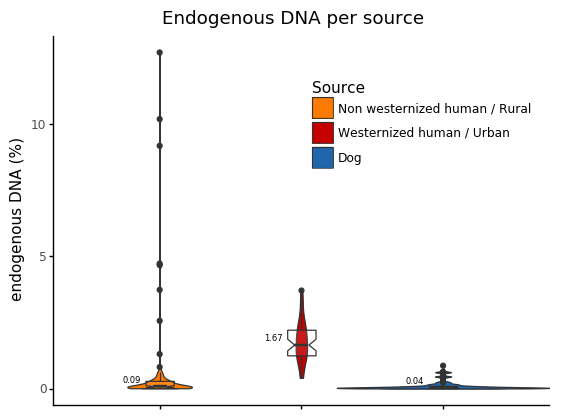

In [34]:
p = ggplot(endo, aes(x="organism", y="percentage_endo")) + geom_violin(aes(fill="organism"))
p = p + geom_violin(aes(fill='organism'), width=1.5)
p = p + geom_boxplot(alpha=0.1, width=0.2, notch=True) 
p = p + geom_text(data = endo_median, mapping = aes(x='organism',y='percentage_endo',label='percentage_endo'), size = 6, nudge_x=-0.2, nudge_y=0.25)
# p = p + geom_dotplot(aes(fill='organism'),binaxis='y', stackdir='center', binwidth=0.05, alpha=0.2, stackratio = 0.4)
p = p + labs(title = 'Endogenous DNA per source', subtitle = "A subtitle",x = '', y='endogenous DNA (%)') 
# p = p + theme_classic() + theme(legend_position = (0.7,0.7), axis_text_x=element_text(angle=45, hjust=1))
p = p + theme_classic() + theme(legend_position = (0.7,0.7), axis_text_x=element_blank())
p = p + scale_fill_manual(name = "Source", values = {"Dog":"#2166ac","Non westernized human / Rural":"#ff7b00","Westernized human / Urban":"#c40000"})
p.draw()
p.save('results/figure2.png', dpi=300)

## Statistical testing

In [17]:
dog_endo = endo.loc[endo.index[endo['organism'] == 'Dog'],'percentage_endo']
w_human_endo = endo.loc[endo.index[endo['organism'] == 'Westernized human / Urban'],'percentage_endo']
nw_human_endo = endo.loc[endo.index[endo['organism'] == 'Non westernized human / Rural'],'percentage_endo'] 

"The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal."

In [21]:
stats.kruskal(dog_endo, w_human_endo, nw_human_endo)

KruskalResult(statistic=117.4070038210566, pvalue=3.2017915333474645e-26)

The *p value* is < 0.05, there is a difference between the medians of the three sources

"The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean."

In [19]:
stats.f_oneway(dog_endo, w_human_endo, nw_human_endo).pvalue

8.426575776074285e-15

The p value is < 0.05, there is a difference between the means of the three sources

#### Dog vs Non westernized human

"This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values."

In [20]:
stats.ttest_ind(dog_endo, nw_human_endo, equal_var=False)

Ttest_indResult(statistic=-2.64131451444152, pvalue=0.0102284646688581)

The p value is < 0.05: non identical in means (H0 rejected)

#### Dog vs Westernized human

In [37]:
stats.ttest_ind(dog_endo, w_human_endo, equal_var=False)

Ttest_indResult(statistic=-14.684350754698706, pvalue=1.286150271412474e-19)

The p value is < 0.05: non identical in means (H0 rejected)

#### Westernized human vs Non Westernized human

In [38]:
stats.ttest_ind(w_human_endo, nw_human_endo, equal_var=False)

Ttest_indResult(statistic=3.1572036006776965, pvalue=0.0021735106827545287)

The p value is < 0.05: non identical in means (H0 rejected)

#### Dog vs all Human

In [39]:
human_endo= endo.loc[endo.index[endo['organism'].isin(['Westernized human / Urban','Non westernized human / Rural'])] ,'percentage_endo']

In [40]:
human_endo.describe()

count    118.000000
mean       1.247484
std        1.912581
min        0.012799
25%        0.070754
50%        0.485618
75%        1.846473
max       12.722235
Name: percentage_endo, dtype: float64

In [41]:
dog_endo.describe()

count    150.000000
mean       0.106391
std        0.158886
min        0.005393
25%        0.018799
50%        0.041548
75%        0.100043
max        0.865627
Name: percentage_endo, dtype: float64

In [42]:
stats.ttest_ind(dog_endo, human_endo, equal_var=False)

Ttest_indResult(statistic=-6.463484127567583, pvalue=2.3870509561751575e-09)

The p value is < 0.05: non identical in means (H0 rejected)